- Notebook identifies the sub-clusters of astrocytes based on the astrocytic gene expression gradient with respect the boarder of striosome

In [3]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import os

- Load the file that contains quantification of gene expression  as function of distance of astrocytes from striosome border

In [ ]:
Astrocyte_Gradient_gn = np.load(r'./processed_data/AP18a_MERFISH/Astrocyte_GenegradAnalysis.npy',allow_pickle = True).item()['Astrocyte']

In [6]:
p_vals = [Astrocyte_Gradient_gn[gn]['p_value'] for gn in Astrocyte_Gradient_gn]
genes = np.array([gn for gn in Astrocyte_Gradient_gn])

- Compute FDR and keep only the genes that are showing significant gene expression gradient

In [7]:
import scipy
adj_pvalues = scipy.stats.false_discovery_control(p_vals,method = 'bh')

In [8]:
keep = adj_pvalues < 0.05
signifincat_gn = genes[keep]

- Keep only astrocytic genes, remove potential contamination from other cells types. To do this, we will run DEG between astrocytes and non-astrocyte cells. 

In [ ]:
MERFISH_adata = ad.read_h5ad(r'./processed_data/2724_Gpe_Gpi_leiden_clustered_mapmycellAnnotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'./processed_data/donor_2724_PosteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included.csv', index_col=0)
MERFISH_adata.obs = MERFISH_adata.obs.join(spatialModuleAnnotation['GrayMatter_MatrixStriosome_clustered'])
# get the distance from Striosome [as per the result from striosome celltype distribution analysis]
Striosome_distance = pd.read_csv(r'./processed_data/Donor_2427_posterior/Striosome_distance.csv',index_col = 0)
MERFISH_adata.obs = MERFISH_adata.obs.join(Striosome_distance)

In [ ]:
# count matrix normalization
import scanpy as sc
MERFISH_adata.X = MERFISH_adata.layers['X_raw'].copy()
total_count = MERFISH_adata.X.sum(axis=-1)
sc.pp.normalize_total(MERFISH_adata, target_sum = np.median(total_count))
sc.pp.log1p(MERFISH_adata)

In [19]:
MERFISH_adata.obs['Is_astro'] = MERFISH_adata.obs['Subclass_name'].astype(str)
MERFISH_adata.obs['Is_astro'] = MERFISH_adata.obs['Is_astro'].replace({nm:'non_astro' for nm in np.unique(MERFISH_adata.obs['Subclass_name']) if nm != 'Astrocyte'})
MERFISH_adata.obs['Is_astro'] = MERFISH_adata.obs['Is_astro'].astype('category')


In [20]:
np.unique(MERFISH_adata.obs['Is_astro'])

array(['Astrocyte', 'non_astro'], dtype=object)

In [ ]:
# run DEG
sc.tl.rank_genes_groups(MERFISH_adata,groupby = 'Is_astro', method = 'wilcoxon',use_raw = False)


In [ ]:
# get the DEG for astrocytes
markers = sc.get.rank_genes_groups_df(MERFISH_adata,'Astrocyte')
astro_gns = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]['names'].values
astro_gns.shape

(120,)

In [23]:
astro_gns

array(['CHI3L1', 'AQP4', 'RGMA', 'APOE', 'GLIS3', 'AEBP1', 'SERPINA3',
       'PSD2', 'EFEMP1', 'TNC', 'BCAN', 'CD44', 'C3', 'SORBS1', 'SLC1A3',
       'HSPB8', 'GFAP', 'PLPP3', 'SPARCL1', 'FAM189A2', 'COL27A1', 'EMP1',
       'WFS1', 'SLC6A11', 'AQP1', 'WLS', 'NTRK3', 'COL5A3', 'WWTR1',
       'SDS', 'MCC', 'HLA-E', 'GJA1', 'COL4A2', 'PARD3', 'ADM', 'CST3',
       'C11orf96', 'PTPRZ1', 'GLI2', 'BMPR1B', 'GLI3', 'WIF1', 'SLC7A2',
       'PIRT', 'NR2E1', 'LTBP1', 'VCAN', 'NTN1', 'GFRA1', 'COL4A1',
       'CXCL14', 'SLC24A4', 'BAIAP3', 'ID2', 'ABI3BP', 'EYA2', 'SYTL4',
       'ADGRV1', 'GEM', 'OAF', 'RAMP1', 'SLC7A10', 'CD96', 'PAX6',
       'EDNRB', 'UST', 'GPC4', 'CLCF1', 'CBLN1', 'IL17RD', 'ADAM12',
       'HPSE2', 'DDR2', 'CTSH', 'SLC5A8', 'ETNPPL', 'CPAMD8', 'CD163',
       'SHISA6', 'SOX5', 'ADAMTS17', 'ECEL1', 'DOCK8', 'MOXD1', 'HS3ST4',
       'SLC14A1', 'TC2N', 'SULF1', 'SHROOM3', 'ZBTB7C', 'TSHZ2', 'RBM47',
       'CPXM2', 'MAP3K15', 'VAX1', 'CA8', 'NPL', 'RGS6', 'EBF3',
      

- Get astrocytic genes that are showing significant genes expression gradient

In [ ]:
sign_astro_gn = [gn for gn in signifincat_gn if gn in astro_gns]

Xpr_bin_est = np.array([Astrocyte_Gradient_gn[gn]['Xpr_bin_est'] for gn in sign_astro_gn])
Xpr_bin_gn = np.array([Astrocyte_Gradient_gn[gn]['Xpr_bin_gn'] for gn in sign_astro_gn])

-  z-score the estimated expression gradient of the gene

In [ ]:
mu = np.mean(Xpr_bin_est, axis = -1, keepdims = True)
std = np.std(Xpr_bin_est, axis = -1, keepdims = True)

std = np.where(std > 1e-11, std, np.inf)

Xpr_bin_est_zscored = (Xpr_bin_est - mu)/std 

- Do k-means to classify the genes, based on their expression pattern

In [ ]:
import sklearn 
kmeans = sklearn.cluster.KMeans(n_clusters = 2).fit(Xpr_bin_est_zscored).labels_

In [27]:
Xpr_bin_est_zscored.shape,kmeans.shape,len(sign_astro_gn)

((74, 21), (74,), 74)

- sort the expression within each kmean cluster 

In [ ]:
sorted_Xpr_bin = []
sorted_sign_astro_gn = []
for k in np.unique(kmeans)[::1]:
    keep = kmeans == k
    sub_Xpr = Xpr_bin_est_zscored[keep]
    idx = np.argsort(np.argmax(sub_Xpr, axis = -1))
    sub_Xpr = sub_Xpr[idx]
    sorted_Xpr_bin.append(sub_Xpr)
    sorted_sign_astro_gn +=[np.array(sign_astro_gn)[keep][idx]]
sorted_Xpr_bin = np.vstack(sorted_Xpr_bin)
sorted_sign_astro_gn = np.hstack(sorted_sign_astro_gn)
sorted_Xpr_bin.shape,sorted_sign_astro_gn.shape

((74, 21), (74,))

- Plot the result as heatmap

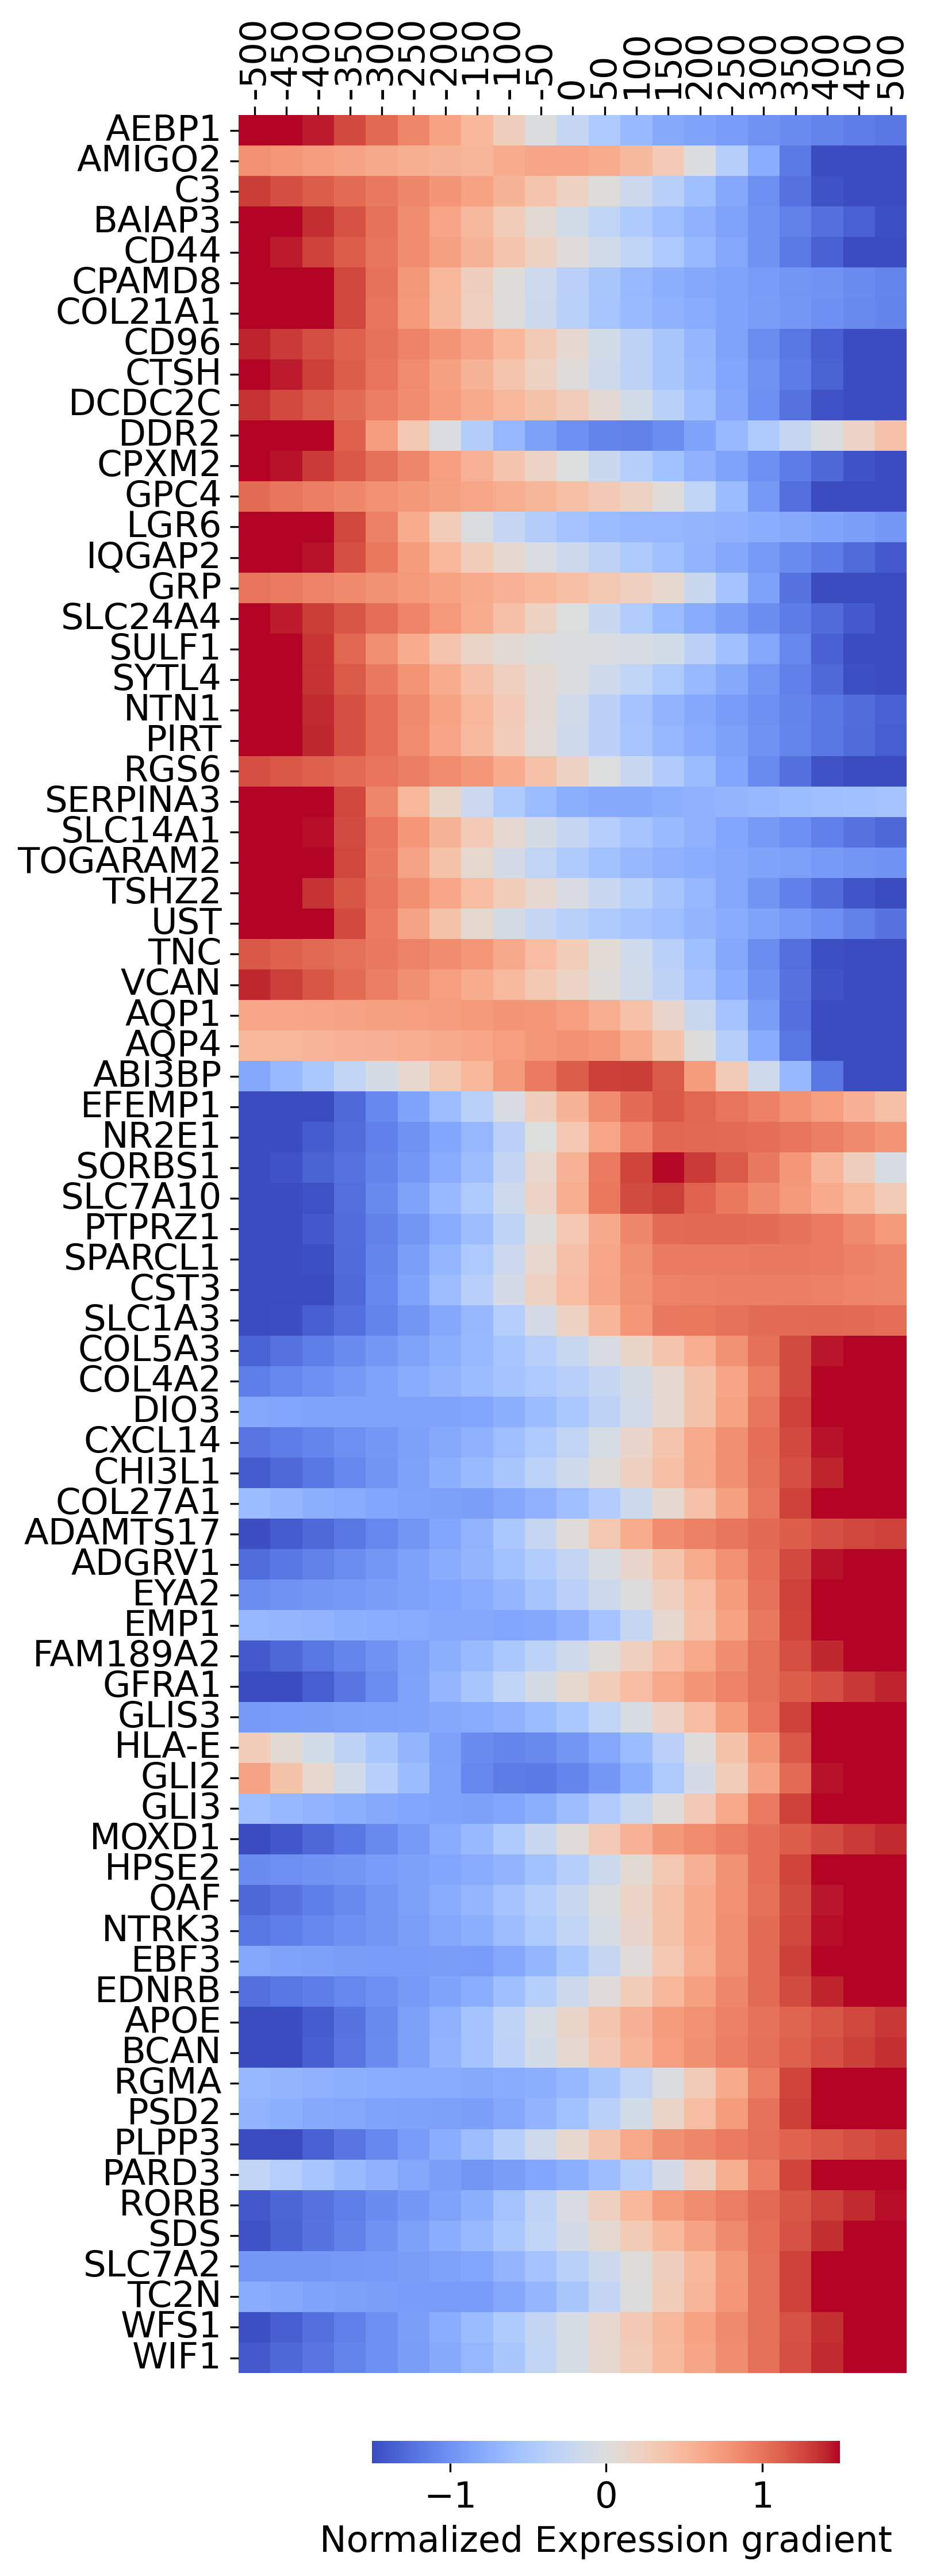

In [ ]:
# heatmap
import seaborn as sns 
import matplotlib as mpl

mpl.rcParams['font.size'] = 15
fig,ax = plt.subplots(1,1,figsize = (5,17), dpi = 300)
bbox = ax.get_position()
cbar_ax = fig.add_axes([bbox.xmin + 0.2*bbox.width,bbox.ymin - 0.04*bbox.height,0.7*bbox.width,0.01*bbox.height])

sns.heatmap(
    # Xpr_bin_est_zscored[np.argsort(kmeans)],
    sorted_Xpr_bin,
    yticklabels = sorted_sign_astro_gn,
    xticklabels = np.arange(-500,501,50),
    cmap = 'coolwarm',
    vmax = 1.5,
    vmin = -1.5,
    ax = ax,
    cbar_kws = {'shrink':0.7,'orientation':'horizontal','label':'Normalized Expression gradient'},
    cbar_ax = cbar_ax
)
ax.xaxis.tick_top()
ax.tick_params('x', labeltop=True, bottom=False, labelbottom=False, labelrotation = 90)
plt.savefig(r'./figures/geneExpressonGradient_heamap_striosomeAstro.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/geneExpressonGradient_heamap_striosomeAstro.png',bbox_inches = 'tight')

In [28]:
np.unique(kmeans)

array([0, 1], dtype=int32)

In [29]:
np.array(sign_astro_gn)[kmeans == 0]

array(['ADAMTS17', 'ADGRV1', 'APOE', 'BCAN', 'CHI3L1', 'COL27A1',
       'COL4A2', 'COL5A3', 'CST3', 'CXCL14', 'DIO3', 'EBF3', 'EDNRB',
       'EFEMP1', 'EMP1', 'EYA2', 'FAM189A2', 'GFRA1', 'GLI2', 'GLI3',
       'GLIS3', 'HLA-E', 'HPSE2', 'MOXD1', 'NR2E1', 'NTRK3', 'OAF',
       'PARD3', 'PLPP3', 'PSD2', 'PTPRZ1', 'RGMA', 'RORB', 'SDS',
       'SLC1A3', 'SLC7A10', 'SLC7A2', 'SORBS1', 'SPARCL1', 'TC2N', 'WFS1',
       'WIF1'], dtype='<U8')

In [30]:
np.array(sign_astro_gn)[kmeans == 1]

array(['ABI3BP', 'AEBP1', 'AMIGO2', 'AQP1', 'AQP4', 'BAIAP3', 'C3',
       'CD44', 'CD96', 'COL21A1', 'CPAMD8', 'CPXM2', 'CTSH', 'DCDC2C',
       'DDR2', 'GPC4', 'GRP', 'IQGAP2', 'LGR6', 'NTN1', 'PIRT', 'RGS6',
       'SERPINA3', 'SLC14A1', 'SLC24A4', 'SULF1', 'SYTL4', 'TNC',
       'TOGARAM2', 'TSHZ2', 'UST', 'VCAN'], dtype='<U8')

In [ ]:
np.save(r'./processed_data/AP26a_MERFISH/significant_astrocytic_gns.npy',sign_astro_gn,allow_pickle = True)

### Sub-clustering of astrocytes based on the astrocytic genes that are showing gradient

In [ ]:
sign_astro_gn = np.load(r'./processed_data/AP26a_MERFISH/significant_astrocytic_gns.npy',allow_pickle = True)

In [51]:
# 1. replace the count with raw count matrix 
MERFISH_adata.X = MERFISH_adata.layers['X_raw'].copy()

# 2. restrict to astrocyte within and around the striosomes
dist_cond = (MERFISH_adata.obs['striosome_distance'] > -200) & (MERFISH_adata.obs['striosome_distance'] < 500)
cellType_cond = MERFISH_adata.obs['Group_name'].isin(['Astrocyte'])
subadata = MERFISH_adata[dist_cond & cellType_cond].copy()

# 3. restrict to the genes used in the gradient analysis
subadata= subadata[:,sign_astro_gn].copy()
subadata


AnnData object with n_obs × n_vars = 19812 × 74
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'GrayMatter_MatrixStriosome_clustered', 'striosome_distance', 'Is_astro'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Ensemble_ID'
    uns: 'Class_name_colors', 'Subclass_name_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap', 'rank_genes_grou

In [52]:
## Count matrix normalization 
total_count = np.sum(subadata.X, axis = -1)
sc.pp.normalize_total(subadata,target_sum = np.median(total_count))
sc.pp.log1p(subadata)

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [53]:
sc.pp.neighbors(subadata, n_neighbors=15, use_rep='X')
sc.tl.leiden(subadata,resolution = 0.3)
sc.tl.umap(subadata, min_dist = 0.1)

In [54]:
np.unique(subadata.obs['leiden'])

array(['0', '1', '2', '3'], dtype=object)

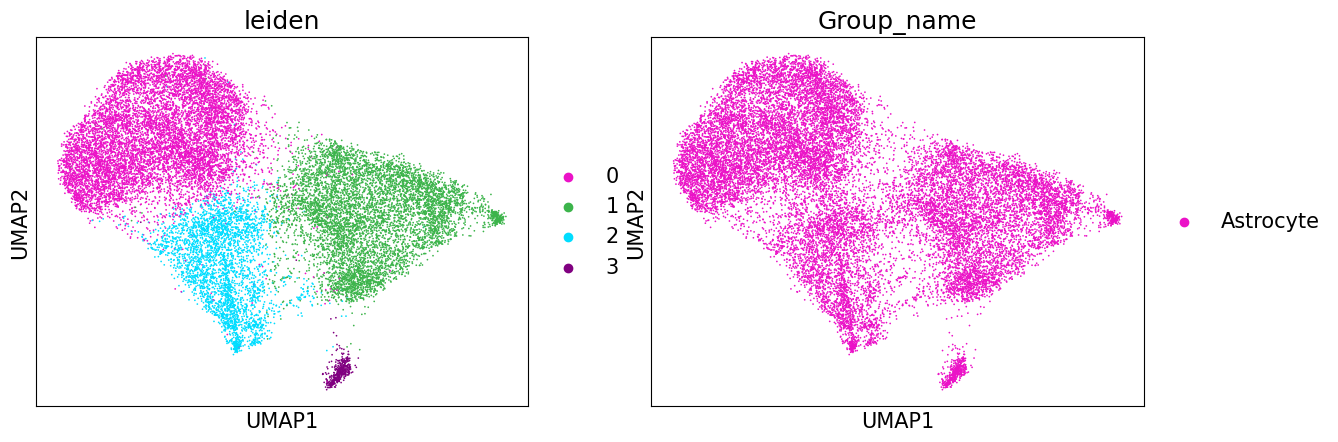

In [55]:
cmap = ["#e6194B", "#3cb44b","#4363d8", "#f58231", "#42d4f4","#911eb4", "#ffe119", "#bfef45", "#da1b1b",
        "#000075", "#aaffc3", "#808000", "#ffd8b1", "#f032e6",[0,0.2,0],
         "#fabed4", "#1AEBD3", "#dcbeff", "#9A6324", "#fffac8", "#800000",]
cmap = ["#EB12C7","#3cb44b", "#00DDFF",'#800080']
sc.pl.umap(subadata,color = ['leiden','Group_name'], palette = cmap )

In [56]:
subadata.obs['leiden_annotated'] = subadata.obs['leiden'].map(lambda x: f'Astro-{x}')

In [ ]:
# save the clustered anndata 
subadata.write_h5ad(r'./processed_data/AP26a_MERIFSH/astrocyte_GradientGn_clustered.h5ad',compression='gzip')

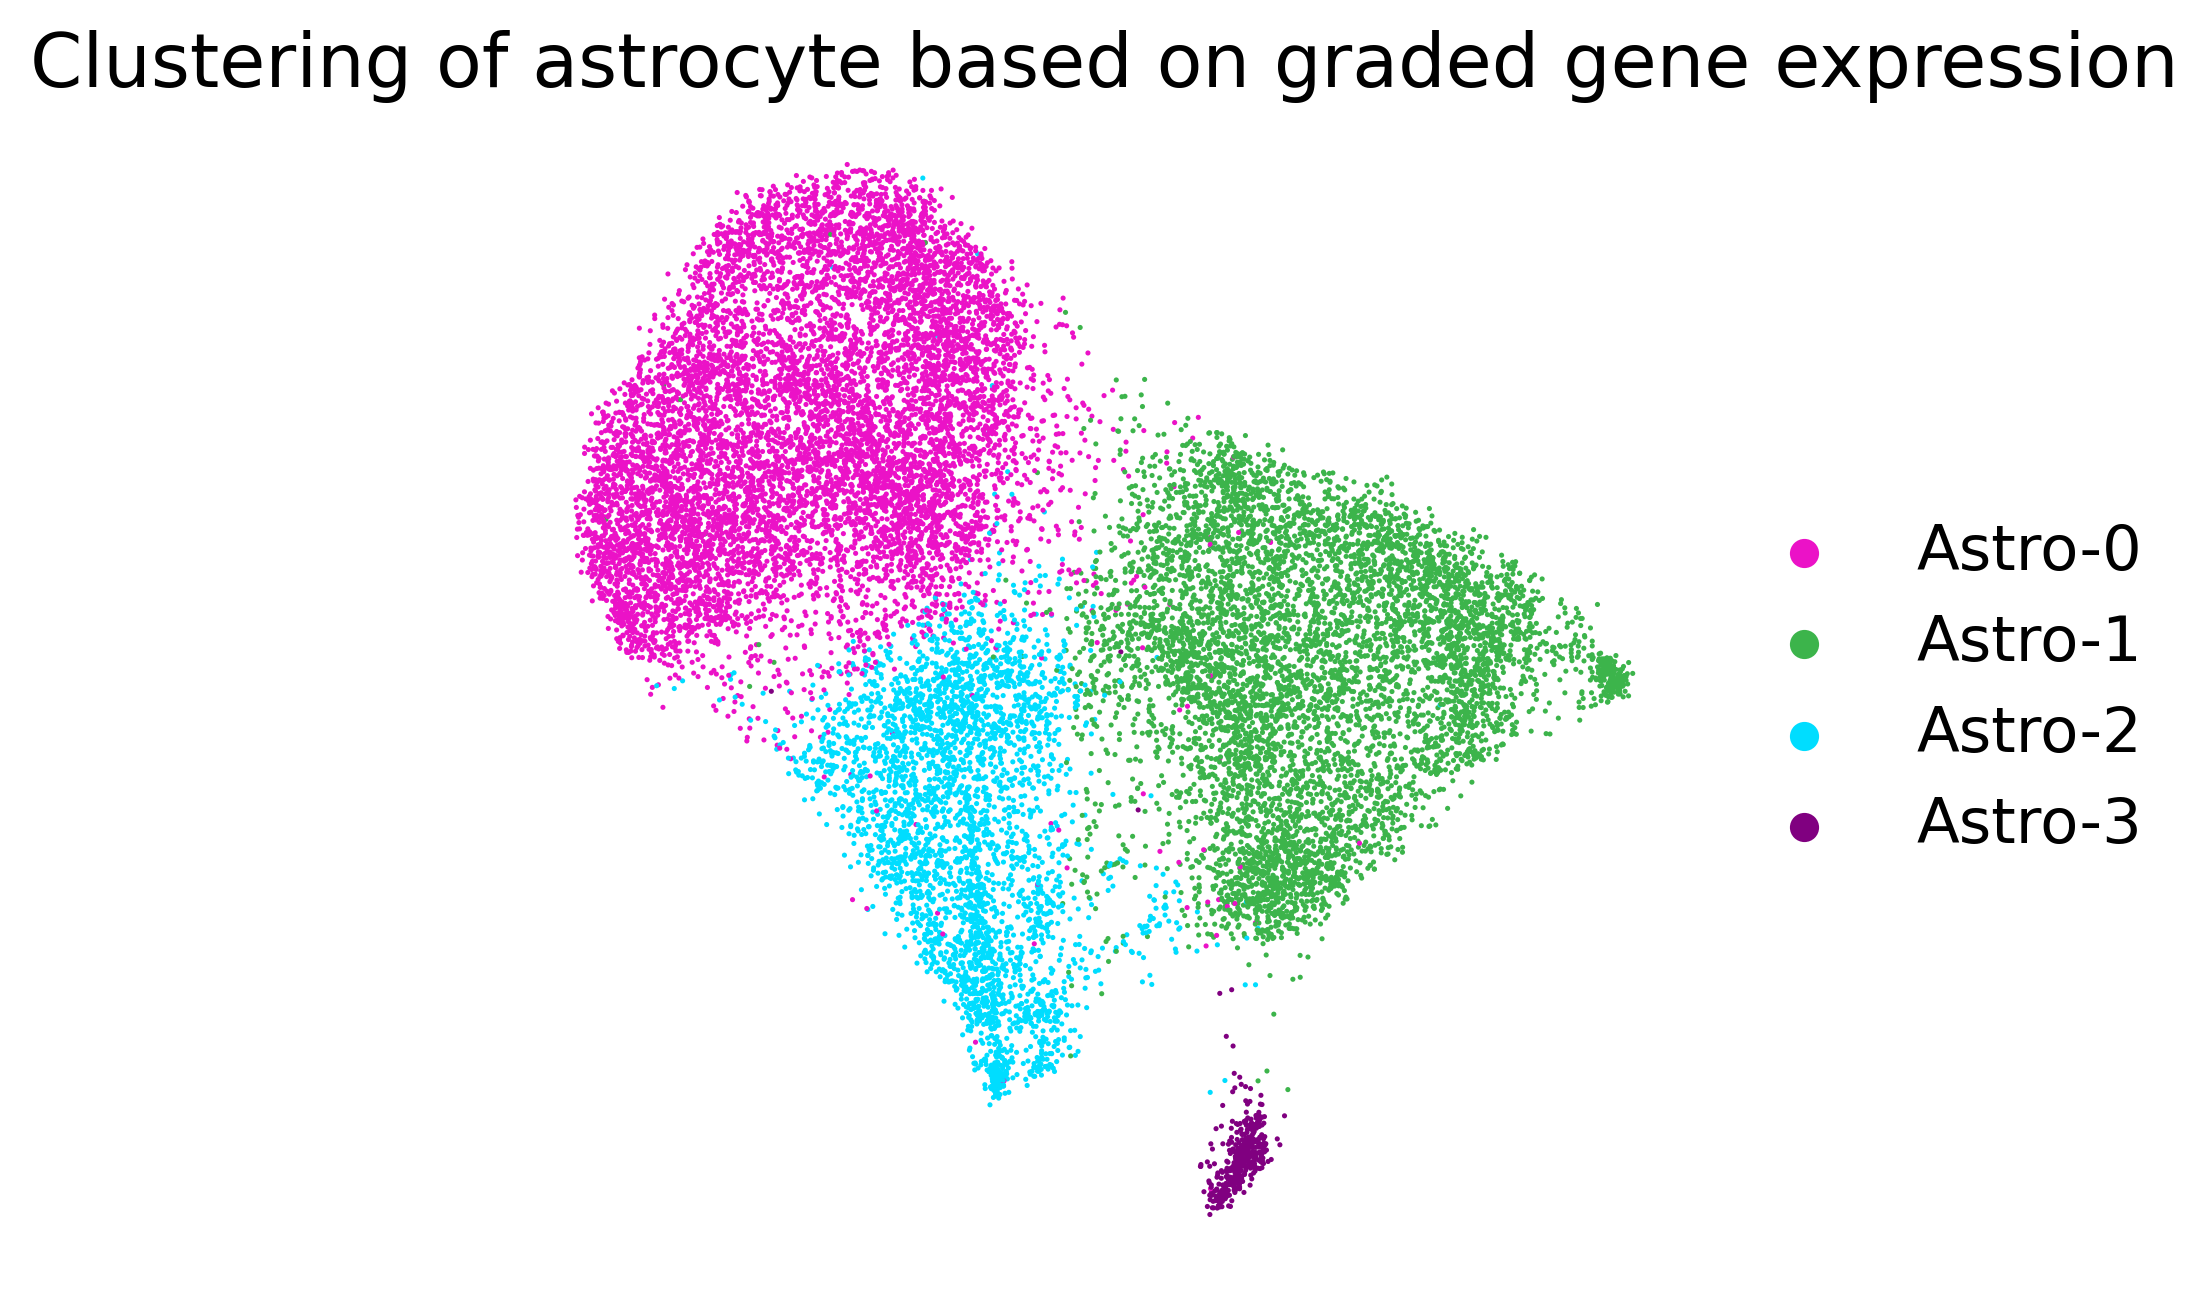

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
import os
fig,ax = plt.subplots(1,1, figsize = (5,5), dpi = 300)
cmap = ["#EB12C7","#3cb44b", "#00DDFF",'#800080']
sc.pl.umap(subadata,color = ['leiden_annotated'], palette = cmap, ax = ax, show = False,  frameon = False, title = 'Clustering of astrocyte based on graded gene expression' )
figure_title = 'geneGradient_based_astrocytesubtype_umap'
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')
plt.show()

- Spatial plots of the clustsers 

In [ ]:
donor_2427_posterior_spatialModuleContours = np.load(r'./processed_data/AP26a_MERFISH/spatialModule_Contourcoord.npy',allow_pickle = True).item()
donor_2427_posterior_StriosomeContours = np.load(r'./processed_data/AP26a_MERFISH/Striosome_Contourcoord.npy',allow_pickle = True).item()


- Check the spatial map 

In [ ]:
# load in the metadata and striosome contours 
meta = pd.read_csv(r'./processed_data/AP26a_MERFISH/Striosome_analyzed_metadata.csv', index_col = 0)
strio_contour = np.load(r'./processed_data/AP26a_MERFISH/Striosome_contours.npy',allow_pickle = True).item()['contours']
subadata.obs['Striosome_label'] = meta.loc[subadata.obs_names,'Striosome_label']

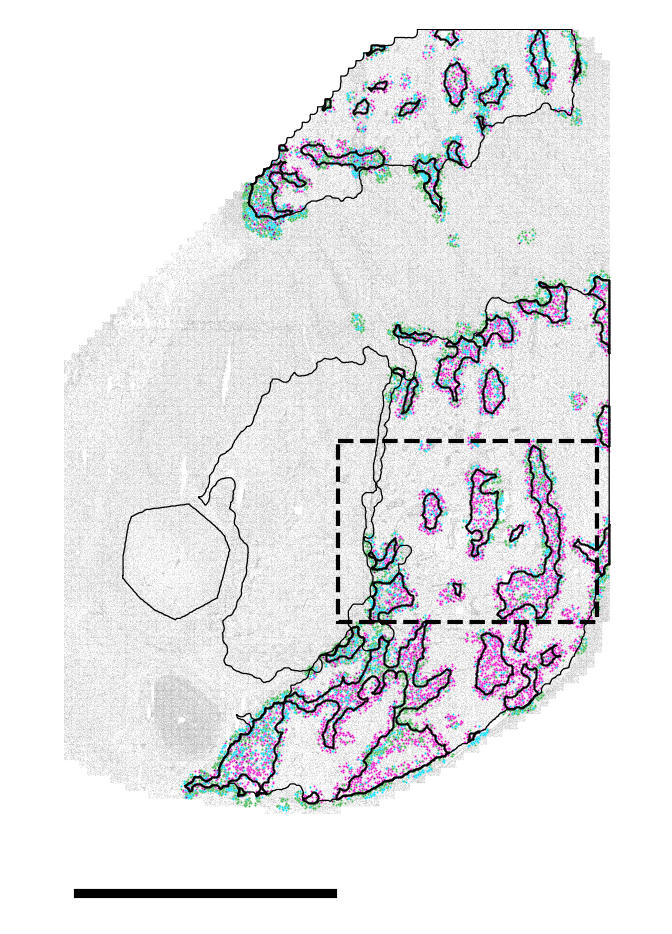

In [ ]:
import seaborn as sns
import matplotlib.patches as patches
dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial'], axis = 0))
figsize_scale = 8e3
nobox = False

figure_title = 'Donor_2724p_striosome_astrocyte'
dx = dx/figsize_scale
dy = dy/figsize_scale
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (dx,dy))
sns.scatterplot(x = MERFISH_adata.obsm['X_spatial'][:,0],y = MERFISH_adata.obsm['X_spatial'][:,1], s = 0.005, c = 'gray', ax = ax)

X = subadata.obsm['X_spatial'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    keep = (subadata.obs['leiden'] == ld).values
    sns.scatterplot(x = X[keep,0],y = X[keep,1], s = 0.25, c = ld_clr, ax = ax)

# add the outregion outlines 
cnt = donor_2427_posterior_spatialModuleContours
for label_ in ['Caudate','Putamen','NAC_shell','NAC_core','Gpi','Gpe',]:
    if label_ in cnt:
        if isinstance(cnt[label_],list):
            for i in range(len(cnt[label_])):
                ax.plot(cnt[label_][i][:,0],cnt[label_][i][:,1], lw = 0.3, c = 'k')
        else:
            ax.plot(cnt[label_][:,0],cnt[label_][:,1], lw = 0.3, c = 'k')

# bbox2 = patches.Rectangle((-100,-1000),10000,7000, fill = False, lw = 1, ls = '--')
bbox2 = patches.Rectangle((-100,-1200),10000,7000, fill = False, lw = 1, ls = '--')
if not nobox:
    ax.add_patch(bbox2)

# Plot the Striosome contours
# add the striosome contour outline
for cnt in donor_2427_posterior_StriosomeContours['Striosome']:
    sns.scatterplot(x = cnt[:,0],y = cnt[:,1], s = 0.1, facecolor = 'k',edgecolor = 'k', ax = ax)

xmax, ymax = MERFISH_adata.obsm['X_spatial'].max(axis=0)
xmin, ymin = MERFISH_adata.obsm['X_spatial'].min(axis=0)
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax + 3500])
# add scale bar
scalebar = patches.Rectangle([xmin + 500,1*ymax + 3000],10000,200,color = 'k')
ax.add_patch(scalebar)
ax.invert_yaxis()
ax.set_axis_off()
ax.set_aspect('equal',adjustable='datalim')
if not nobox:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')
else:
    plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '_nobox.png',bbox_inches = 'tight')
    plt.savefig(r'./figures/StriosomeFocus_Figure'+ os.sep + figure_title + '_nobox.tif',bbox_inches = 'tight')




plt.show()

    

- Plot the zoom-in box separately 

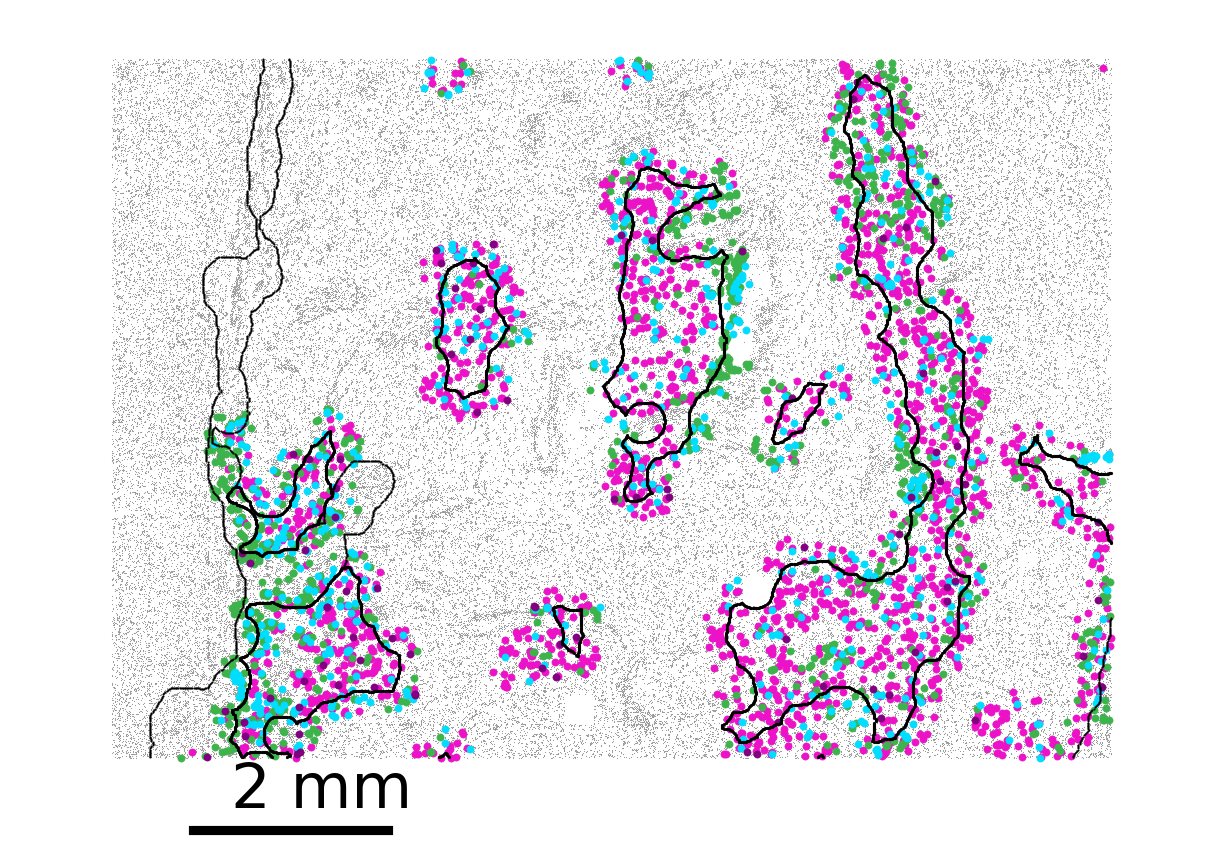

In [ ]:
figsize_scale = 2e3
xmin,ymin, xmax, ymax = np.array(bbox2.get_bbox()).ravel()
cond1 = (MERFISH_adata.obsm['X_spatial'][:,0] >= xmin) & (MERFISH_adata.obsm['X_spatial'][:,0] <= xmax)
cond2 = (MERFISH_adata.obsm['X_spatial'][:,1] >= ymin) & (MERFISH_adata.obsm['X_spatial'][:,1] <= ymax)

dx,dy = np.abs(np.ptp(MERFISH_adata.obsm['X_spatial'][cond1 & cond2], axis = 0))
dx = dx/figsize_scale
dy = dy/figsize_scale
nobox = False

fig,ax = plt.subplots(1,1,dpi = 300, figsize = (dx, dy))

sns.scatterplot(x = MERFISH_adata[cond1 & cond2].obsm['X_spatial'][:,0],y = MERFISH_adata[cond1 & cond2].obsm['X_spatial'][:,1], s = 0.07, c = 'gray', ax = ax)


ax.set_axis_off()
# # Plot the Striosome contours
# for i,cont in enumerate(strio_contour):
#     strio_cond1 = (cont[:,0] >= xmin) & (cont[:,0] <= xmax)
#     strio_cond2 = (cont[:,1] >= ymin) & (cont[:,1] <= ymax)
#     cnt_ = cont[strio_cond1 & strio_cond2,:]
#     if cnt_.size > 0:
#         cnt_ = np.vstack([cnt_,cnt_[0,:]])
#         ax.plot(cnt_[:,0],cnt_[:,1],'k',lw = 0.4)
#         # sns.scatterplot(x = cnt_[:,0],y = cnt_[:,1],c = 'k',ax = ax, s = 5)



X = subadata.obsm['X_spatial'].copy()

for ld_clr,ld in zip(subadata.uns['leiden_colors'],subadata.obs['leiden'].cat.categories):
    ld_keep = (subadata.obs['leiden'] == ld).values
    cond1 = (subadata.obsm['X_spatial'][:,0] >= xmin) & (subadata.obsm['X_spatial'][:,0] <= xmax)
    cond2 = (subadata.obsm['X_spatial'][:,1] >= ymin) & (subadata.obsm['X_spatial'][:,1] <= ymax)
    sns.scatterplot(x = X[ld_keep & cond1 & cond2,0],y = X[ld_keep & cond1 & cond2,1], s = 3, facecolor = ld_clr,edgecolor = ld_clr, ax = ax)


# add the striosome contour outline
for cnt in donor_2427_posterior_StriosomeContours['Striosome']:
    strio_cond1 = (cnt[:,0] >= xmin) & (cnt[:,0] <= xmax)
    strio_cond2 = (cnt[:,1] >= ymin) & (cnt[:,1] <= ymax)
    sns.scatterplot(x = cnt[strio_cond1 & strio_cond2,0],y = cnt[strio_cond1 & strio_cond2,1], s = 0.5, facecolor = 'k',edgecolor = 'k', ax = ax)      

# add the spatial region outline 
for label_ in ['Caudate','Putamen','Gpe']:
    cnt = donor_2427_posterior_spatialModuleContours[label_].copy()
    cnt_cond1 = (cnt[:,0] >= xmin) & (cnt[:,0] <= xmax)
    cnt_cond2 = (cnt[:,1] >= ymin) & (cnt[:,1] <= ymax)
    cnt = cnt[cnt_cond1 & cnt_cond2,:]
    if 'gp' in label_.lower():
        sns.scatterplot(x = cnt[:,0],y = cnt[:,1], s = 0.2, facecolor = 'k',edgecolor = 'k', ax = ax)
    else:
        sns.scatterplot(x = cnt[:,0], y = cnt[:,1], s = 0.2, facecolor = 'k',edgecolor = 'k', ax = ax)

# add scalebar 
xmin,ymin = np.min(X[cond1 & cond2],axis = 0)
xmax,ymax = np.max(X[cond1 & cond2],axis = 0)
import matplotlib.patches as patches
scalebar = patches.Rectangle([xmin + 100, ymax + 700],2000,50, color = 'k')
ax.add_patch(scalebar)
ax.text(xmin + 500, ymax + 500, '2 mm')

ax.set_ylim([ymin - 300,ymax + 800])
ax.invert_yaxis()
ax.set_aspect('equal',adjustable='datalim')
figure_title = '2724P_Striosome_astrocyte_zoominView'
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.png',bbox_inches = 'tight')
plt.savefig(r'./figures/StriosomeFocus_Figure' + os.sep + figure_title + '.tif',bbox_inches = 'tight')

plt.show()
